In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import lightgbm as lgb
import datetime
import re
from bayes_opt import BayesianOptimization

In [2]:
df = pd.read_csv('./train/final_all_onehotencoding_v3.csv', index_col = 0)

obj_columns = df.select_dtypes(include=['object']).columns
# Apply one-hot encoding to object columns
df = pd.get_dummies(df, columns = obj_columns, drop_first = True)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df = df.loc[:, ~df.columns.duplicated()]

y = df.TARGET
X = df.drop('TARGET', axis = 1)
X = X.replace([np.inf, -np.inf], np.nan)
X.fillna(0.0, inplace = True)

# train, val, test : 0.9, 0.05, 0.05
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size = 0.1, random_state = 37)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size = 0.5, random_state = 37)

data_dmatrix = lgb.Dataset(data=X_train,label=y_train)

[LightGBM] [Info] Number of positive: 22361, number of negative: 254398
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19993
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431582
[LightGBM] [Info] Start training from score -2.431582

程式執行花費的时间： 8.72 秒
完成时间: 2023-09-12 09:18:49.684504


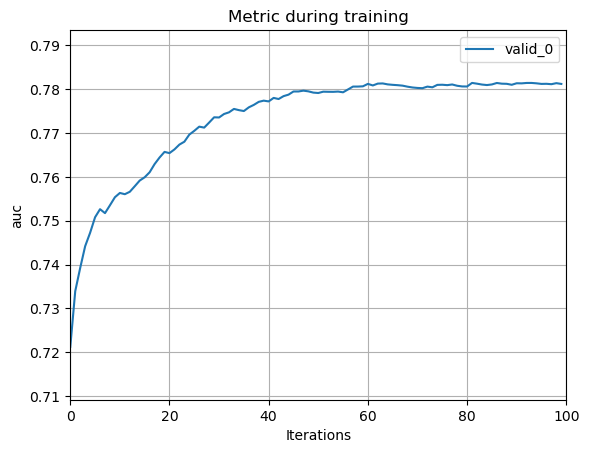

In [3]:
# FRANK 版本
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

params = {
    'boosting_type':'dart', 
    'objective': 'binary',
    'is_unbalance': 'true',
    # 'device': 'gpu',
    'n_estimators': 10000,
    'metric': 'auc',
    'max_bins': 41,
    'early_stopping_round':1000,
    'learning_rate' : 0.01,
    'num_leaves': 43, # 95
    'bagging_freq': 1,
    'subsample' : 0.7001, # 0.7001, 0.906, 0.2245
    'max_depth': 9, # 8
    'reg_alpha': 0.9134, # 0.9134, 0.6312
    'reg_lambda': 0.484, # 0.484, 0.8881
    'scale_pos_weight': 14,
    'colsample_bytree': 0.6674,
    'min_child_weight': 93,
    'min_split_gain': 0.6243,
    'verbosity': 1,
    'n_jobs' : -1,
}

evals_result = {}

start_time = time.time()

gbm = lgb.LGBMClassifier(**params)
gbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.record_evaluation(evals_result)],
)

end_time = time.time()
execution_time = end_time - start_time


# After training
# for iteration, auc_values in enumerate(evals_result['valid_0']['auc'], start=1):
#     if iteration % 10 == 0:  # Print every 10 iterations
#         print(f'迭代 {iteration}: AUC = {auc_values:.4f}')

print("\n程式執行花費的时间：", round(execution_time, 2), "秒")
print("完成时间:", datetime.datetime.now())

# Plot the recorded evaluation metric (AUC)
lgb.plot_metric(evals_result, metric='auc')
plt.show()

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


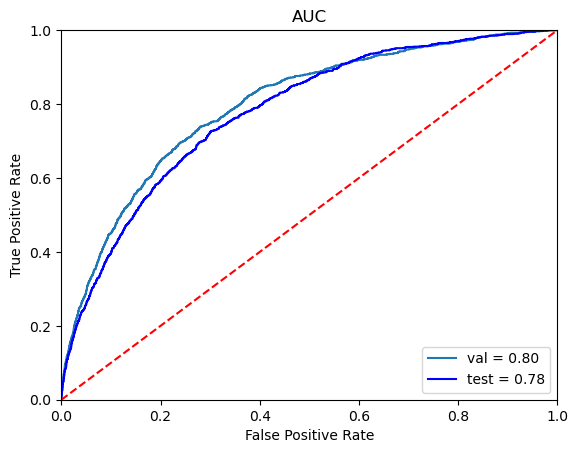

In [4]:
y_pred_prob = gbm.predict_proba(X_val)
y_pred_prob = y_pred_prob[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_val, y_pred_prob)
auc = metrics.roc_auc_score(y_val, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="val = %0.2f" % roc_auc)

y_pred_prob = gbm.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.title('AUC')
plt.plot(fpr, tpr, 'b', label='test = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [5]:
from sklearn.metrics import roc_curve, auc
# 初始化验证集和测试集的真实标签
y_true_valid = y_val
y_true_test = y_test

# 获取迭代次数和AUC值的记录
iterations = np.arange(1, len(evals_result['valid_0']['auc']) + 1)
valid_auc_values = evals_result['valid_0']['auc']

# 初始化存储AUC值的列表
valid_auc = []
test_auc = []

# 根据每个迭代次数计算验证集和测试集的AUC值
for iteration in iterations:
    # 使用模型的predict_proba方法来获取概率值
    y_pred_prob_valid = gbm.predict_proba(X_val, num_iteration=iteration)[:, 1]
    y_pred_prob_test = gbm.predict_proba(X_test, num_iteration=iteration)[:, 1]
    
    # 计算验证集和测试集的ROC曲线
    fpr_valid, tpr_valid, _ = roc_curve(y_true_valid, y_pred_prob_valid)
    fpr_test, tpr_test, _ = roc_curve(y_true_test, y_pred_prob_test)
    
    # 计算验证集和测试集的AUC值
    roc_auc_valid = auc(fpr_valid, tpr_valid)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # 将AUC值添加到列表中
    valid_auc.append(roc_auc_valid)
    test_auc.append(roc_auc_test)

# 绘制AUC曲线
plt.figure(figsize=(10, 6))
plt.plot(iterations, valid_auc, label=f'Validation AUC = {valid_auc[-1]:.4f})', marker='o')
plt.plot(iterations, test_auc, label=f'Test AUC = {test_auc[-1]:.4f})', marker='x')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('AUC vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging

KeyboardInterrupt: 

Pipeline 寫法 (Z-score & LGBMClassfier) => 成效不彰

In [ ]:
# params = {
#             'boosting_type': 'gbdt',
#             'objective': 'binary',
#             # 'scale_pos_weight' : 14,
#             'is_unbalance': 'true',
#             'device': 'gpu',
#             'max_bins': 63,
#             'n_estimators': 100,
#             'metric': 'auc',
#             'verbosity': 1
#             }
#             # 'boosting_type':'gbdt', 'class_weight':'balanced', 'colsample_bytree':1.0,
#             # 'importance_type':'split', 'learning_rate':0.01, 'max_depth':-1,
#             # 'max_bins':63,
#             # 'min_child_samples':20, 'min_child_weight':0.001, 'min_split_gain':0.0,
#             # 'n_estimators':100, 'device':'gpu', 'num_leaves':31, 'objective':"binary",
#             # 'reg_alpha':0.1, 'reg_lambda':0.1, 'silent':True, 'early_stopping_rounds': 20,
#             # 'subsample':1.0, 'subsample_freq':0}

# pipe_lgb = Pipeline([('scaler', StandardScaler()), ('lgb', lgb.LGBMClassifier(**params))])
# # pipe_lgb = Pipeline([('scaler', StandardScaler()), ('lgb', lgb.LGBMClassifier())])
# evals_result = {}

# t0 = time.time()
# pipe_lgb.fit(X_train.values, y_train.values,
#             lgb__eval_set = [(X_train.values, y_train.values), (X_test.values, y_test.values)],
#             lgb__eval_names = ['train', 'val'],
#             lgb__eval_metric = 'auc',
#             lgb__callbacks=[lgb.record_evaluation(evals_result)] 
#             )
# t1 = time.time()
# y_pred = pipe_lgb.predict(X_test)
# y_trainPred = pipe_lgb.predict(X_train)

# print('LightGBM elapse time: {}'.format(t1-t0))
# print("完成时间:", datetime.datetime.now())

# # Plot the recorded evaluation metric (AUC)
# lgb.plot_metric(evals_result, metric='auc')
# plt.show()

In [ ]:
# accuracy=accuracy_score(y_pred, y_test)
# print('LightGBM Model test accuracy score: {0:0.4f}'.format(accuracy))

# results = pipe_lgb.named_steps["lgb"].evals_result_
# epochs = len(results['train']['auc'])
# x_axis = range(0, epochs)
# acc = [np.abs(1-x) for x in results['train']['auc']]
# acc2 = [np.abs(1-x) for x in results['val']['auc']]
# fig, ax = plt.subplots()
# ax.plot(x_axis, acc, label='Train')
# ax.plot(x_axis, acc2, label='Test')
# ax.legend()
# plt.xlabel('epoch')
# plt.ylabel('accuracy rate')
# plt.title('LightGBM ACC')
# plt.show()

In [14]:
from sklearn.metrics import confusion_matrix

y_pred = gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0]) # 實際沒違約，預測正確
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0]) # 實際違約，預測卻沒有

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Confusion matrix

 [[9893 4276]
 [ 340  867]]

True Positives(TP) =  9893

True Negatives(TN) =  867

False Positives(FP) =  4276

False Negatives(FN) =  340


<Axes: >

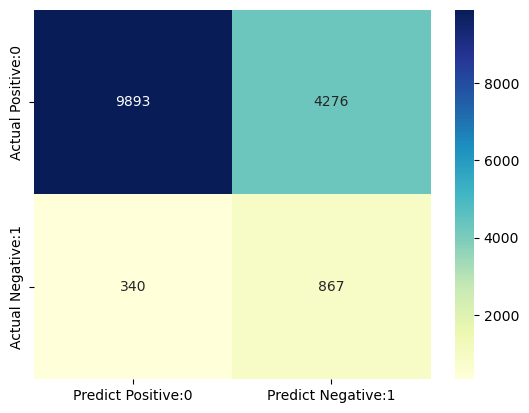

In [15]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Positive:0', 'Predict Negative:1'], 
                                 index=['Actual Positive:0', 'Actual Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.75      0.85     14169
           1       0.18      0.65      0.29      1207

    accuracy                           0.75     15376
   macro avg       0.57      0.70      0.57     15376
weighted avg       0.90      0.75      0.80     15376



In [ ]:
# feature_importances = pipe_lgb.steps[1][1].feature_importances_
# # Get feature names from the pipeline
# feature_names = X_train.columns

# # Sort feature importances in ascending order
# sorted_indices = np.argsort(feature_importances)[::1]
# sorted_feature_importances = feature_importances[sorted_indices]
# sorted_feature_names = feature_names[sorted_indices]

# important_indices = np.where(sorted_feature_importances != 0)[0]
# important_feature_importances = sorted_feature_importances[important_indices]
# important_feature_names = sorted_feature_names[important_indices]
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(important_feature_importances)), important_feature_importances, tick_label=important_feature_names)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('LightGBM Classifier Feature Importances')
# plt.tight_layout()
lgb.plot_importance(gbm, max_num_features= 20, importance_type='split', xlabel= 'split') # numbers of times the feature is used in a model
plt.show()

In [ ]:
booster = gbm.booster_
feature_name = booster.feature_name()
print(len(feature_name))

In [ ]:
import pickle

# save the model to disk
filename = 'LightGBM_v3.sav'
pickle.dump(gbm, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

調參工具: 貝葉斯優化

In [16]:
def lgb_evaluate(**params):
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['max_bins'] = int(params['max_bins'])
    # params['bagging_freq'] = int(params['bagging_freq'])
    
# bayes: 0.785(eta + iter) => (l1 + 12) => (num_leaves + max_depth + max_bins)
    clf = lgb.LGBMClassifier(**params, 
                         learning_rate = 0.01,
                         n_estimators = 6600,
                         nthread = 5, 
                         scale_pos_weight = 14,
                         boosting_type='gbdt', 
                         objective='binary',
                         early_stopping_rounds = 600,
                        #  num_leaves = 31,
                         n_jobs = -1,
                         verbosity=-1)

    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=37)
        
    test_pred_proba = np.zeros(df.shape[0])
    # test_pred_proba = np.zeros(y_test.shape[0])
    
    feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    # 4 : 1 輪流
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df['TARGET'])):
        train_x, train_y = df[feats].iloc[train_idx], df['TARGET'].iloc[train_idx]
        val_x, val_y = df[feats].iloc[valid_idx], df['TARGET'].iloc[valid_idx]
        
        clf.fit(train_x, train_y,
                eval_set = [(train_x, train_y), (val_x, val_y)], 
                eval_metric = 'auc',
                )

        test_pred_proba[valid_idx] = clf.predict_proba(val_x, num_iteration = clf.best_iteration_)[:, 1]
        del train_x, train_y, val_x, val_y

    return roc_auc_score(df['TARGET'], test_pred_proba)
    # return roc_auc_score(y_test, test_pred_proba)

In [17]:
init_time = time.time()
params = {
          'num_leaves': (20, 100), 
        #   'bagging_freq': (.0, 1.0),
          'subsample' : (.1, 1.0),
          'max_depth': (4, 10), 
          'max_bins' : (20, 63),
          'reg_alpha': (.0, 1.0), 
          'reg_lambda': (.0, 1.0), 
          'min_split_gain': (.0, 1.0),
          'min_child_weight': (20, 100),
          'colsample_bytree': (.1, 1.0), # feature_fraction
           }
bo = BayesianOptimization(lgb_evaluate, params)
bo.maximize(init_points = 5, n_iter = 5)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

|   iter    |  target   | colsam... | max_bins  | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7076    | 0.6186    | 45.18     | 4.137     | 64.75     | 0.1667    | 62.4      | 0.9847    | 0.4536    | 0.6295    |
| 2         | 0.7229    | 0.6405    | 31.57     | 8.88      | 77.39     | 0.1216    | 24.36     | 0.7035    | 0.2518    | 0.6205    |
| 3         | 0.734     | 0.705     | 47.48     | 6.746     | 41.04     | 0.2362    | 88.67     | 0.7588    | 0.8743    | 0.1806    |
| 4         | 0.7403    | 0.5243    | 39.14     | 8.366     | 93.2      | 0.8225    | 95.19     | 0.9632    | 0.3305    | 0.8979    |
| 5         | 0.738     | 0.8028    | 31.0      | 7.24      | 53.99     | 0.006182  | 87.3      | 0.4874    | 0.119     | 0.8703    |
| 6         | 0.7411    | 0.6674    | 41.0      | 9.322     | 

In [ ]:
# init_time = time.time()
# params = {'learning_rate': (.01, .03), # 0.02
#           'num_leaves': (20, 100), # 20, 29
#           'subsample': (0.8, 1), # 0.9
#           'max_depth': (6, 9), # 6, 9
#           'reg_alpha': (.00, 1.0), # 0.31, 0.05
#           'reg_lambda': (.00, 1.0), # 0.12, 0.78
#           'min_split_gain': (.01, .03), # 0.03, 0.02
#           'min_child_weight': (20, 70)} # 34, 58
# bo = BayesianOptimization(lgb_evaluate, params)
# bo.maximize(init_points = 5, n_iter = 5)
# print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

In [ ]:
# def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
#     # prepare data
#     train_data = lgb.Dataset(data=X, label=y, categorical_feature = categorical_feats, free_raw_data=False)
#     # parameters
#     def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
#         params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
#         params["num_leaves"] = int(round(num_leaves))
#         params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#         params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
#         params['max_depth'] = int(round(max_depth))
#         params['lambda_l1'] = max(lambda_l1, 0)
#         params['lambda_l2'] = max(lambda_l2, 0)
#         params['min_split_gain'] = min_split_gain
#         params['min_child_weight'] = min_child_weight
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
#         return max(cv_result['auc-mean'])
#     # range 
#     lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
#                                             'feature_fraction': (0.1, 0.9),
#                                             'bagging_fraction': (0.8, 1),
#                                             'max_depth': (5, 8.99),
#                                             'lambda_l1': (0, 5),
#                                             'lambda_l2': (0, 3),
#                                             'min_split_gain': (0.001, 0.1),
#                                             'min_child_weight': (5, 50)}, random_state=0)
#     # optimize
#     lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
#     # output optimization process
#     if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
#     # return best parameters
#     return lgbBO.res['max']['max_params']

# opt_params = bayes_parameter_opt_lgb(X_val, y_val, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.05)